<a href="https://colab.research.google.com/github/BharathiDhereddy/Udacity-AI-ML-Project2/blob/main/Udacity_2nd_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install git if it is not already installed
!apt-get install -q git

# Clone the repository created in the github account
!git clone https://github.com/BharathiDhereddy/udacity-image-classification.git

# Moving all files and folders to the /content folder
!mv udacity-image-classification/* /content/

# Optional: Removing the non-empty directory
!rm -r udacity-image-classification

Reading package lists...
Building dependency tree...
Reading state information...
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'udacity-image-classification'...
remote: Enumerating objects: 8526, done.
remote: Total 8526 (delta 0), reused 0 (delta 0), pack-reused 8526 (from 1)
Receiving objects: 100% (8526/8526), 330.32 MiB | 21.43 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (8197/8197), done.
mv: cannot move 'udacity-image-classification/assets' to '/content/assets': Directory not empty
mv: cannot move 'udacity-image-classification/flowers' to '/content/flowers': Directory not empty


# Use Google Colab

Use T4 GPU

For it Click on the drop-down box - connect
then change runtime type
select T4 GPU
Saved**

In [2]:
# Import necessary packages for image classification

import time
from PIL import Image
import torch
from collections import OrderedDict
from torch import optim
from torch import nn
import torch.nn.functional as F
import json
from torchvision import datasets, models
from torchvision import  transforms as tfs

import numpy as np
import matplotlib.pyplot as plt


print("Necessary Libraries are  imported successfully.")

Necessary Libraries are  imported successfully.


In [3]:
# Defining the directories
dataset_dir = 'flowers'
training_dir = dataset_dir + '/train'
validation_dir = dataset_dir + '/valid'
testing_dir = dataset_dir + '/test'

# Define transformations for the training dataset
training_transforms = tfs.Compose([tfs.RandomRotation(30),
                                       tfs.RandomResizedCrop(224),
                                       tfs.RandomHorizontalFlip(),
                                       tfs.ToTensor(),
                                       tfs.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# Define transformations for the validation dataset
validation_transforms = tfs.Compose([tfs.Resize(256),
                                       tfs.CenterCrop(224),
                                       tfs.ToTensor(),
                                       tfs.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Define transformations for the testing dataset
testing_transforms = tfs.Compose([tfs.Resize(256),
                                      tfs.CenterCrop(224),
                                      tfs.ToTensor(),
                                      tfs.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Loading dataset with ImageFolder
train_data = datasets.ImageFolder(training_dir, transform=training_transforms)
test_data = datasets.ImageFolder(testing_dir, transform=testing_transforms)
valid_data = datasets.ImageFolder(validation_dir, transform=validation_transforms)

# Defining the dataloaders for loading the dataset
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

print("Data has loaded successfully.")

Data has loaded successfully.


In [4]:
# Loading and mapping from Category Label to Category Name
with open('cat_to_name.json', 'r') as fs:
    cat_to_name = json.load(fs)

print("Category to name mapping loaded successfully.")

Category to name mapping loaded successfully.


In [5]:
# Loading a pre-trained vgg16 network
Model = models.vgg16_bn(pretrained=True)

# Freezing parameters so we don't backprop through them.
for params in Model.parameters():
    params.requires_grad = False

# Unfreezing the classifier parameters
for param in Model.classifier.parameters():
    param.requires_grad = True

# Defining a new and untrained feed-forward network as a classifier
clf = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
Model.classifier = clf

print("Model has been built successfully.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has been built successfully.


In [6]:
# Set the device to GPU or CPU
devices = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model.to(devices)

criteria = nn.NLLLoss()
optimizers = optim.Adam(Model.classifier.parameters(), lr=0.001)

epochs = 10
steps = 0
print_every = len(trainloader)  # This ensures the summary is printed once per epoch

for epoch in range(epochs):
    runningloss = 0
    for input, label in trainloader:
        steps += 1

        input, label = input.to(devices), label.to(devices)

        optimizers.zero_grad()

        logps = Model.forward(input)
        loss = criteria(logps, label)
        loss.backward()
        optimizers.step()

        runningloss += loss.item()

        if steps % print_every == 0:
            validloss = 0
            acc = 0
            Model.eval()
            with torch.no_grad():
                for input, label in validloader:
                    input, label = input.to(devices), label.to(devices)
                    logps = Model.forward(input)
                    batchloss = criteria(logps, label)

                    validloss += batchloss.item()

                    # Calculatiing the accuracy of the model
                    p = torch.exp(logps)
                    top_p, top_class = p.topk(1,dim=1)
                    equal = top_class == label.view(*top_class.shape)
                    acc += torch.mean(equal.type(torch.FloatTensor)).item()

            print(f"Epochs: {epoch+1}/{epochs}.. "
                  f"Train Loss: {runningloss/len(trainloader):.3f}.. "
                  f"Validation Loss: {validloss/len(validloader):.3f}.. "
                  f"Validation Accuracy: {acc/len(validloader) * 100:.2f}%")
            runningloss = 0
            Model.train()

print("Training completed successfully.")

Epochs: 1/10.. Train Loss: 2.495.. Validation Loss: 0.616.. Validation Accuracy: 82.84%
Epochs: 2/10.. Train Loss: 0.934.. Validation Loss: 0.479.. Validation Accuracy: 86.57%
Epochs: 3/10.. Train Loss: 0.737.. Validation Loss: 0.393.. Validation Accuracy: 89.54%
Epochs: 4/10.. Train Loss: 0.653.. Validation Loss: 0.310.. Validation Accuracy: 91.11%
Epochs: 5/10.. Train Loss: 0.590.. Validation Loss: 0.303.. Validation Accuracy: 92.33%
Epochs: 6/10.. Train Loss: 0.570.. Validation Loss: 0.384.. Validation Accuracy: 89.93%
Epochs: 7/10.. Train Loss: 0.521.. Validation Loss: 0.275.. Validation Accuracy: 93.03%
Epochs: 8/10.. Train Loss: 0.518.. Validation Loss: 0.304.. Validation Accuracy: 92.00%
Epochs: 9/10.. Train Loss: 0.514.. Validation Loss: 0.374.. Validation Accuracy: 90.99%
Epochs: 10/10.. Train Loss: 0.511.. Validation Loss: 0.278.. Validation Accuracy: 93.51%
Training completed successfully.


In [7]:
# Test the network
testloss = 0
acc = 0
Model.eval()
with torch.no_grad():

    for input, label in testloader:  # Replace 'dataloaders['test']' with 'testloader'
        input, label = input.to('cuda'), label.to('cuda')
        logps = Model.forward(input)
        batchloss = criteria(logps, label)
        testloss += batchloss.item()


        p = torch.exp(logps)
        top_p, top_class = p.topk(1, dim=1)
        equal = top_class == label.view(*top_class.shape)
        acc += torch.mean(equal.type(torch.FloatTensor)).item()

print(f"Test Loss: {testloss/len(testloader):.3f}.. "  # Also replace here
      f"Test Accuracy: {acc/len(testloader):.3f}")  # And here

Test Loss: 0.331.. Test Accuracy: 0.911


In [8]:
Model.class_to_idx = train_data.class_to_idx

checkpoint = {
    'state_dict': Model.state_dict(),
    'class_to_idx': Model.class_to_idx
}

torch.save(checkpoint, 'checkpoint.pth')

In [9]:

def load_checkpoint(file_path):
    checkpoint = torch.load(file_path)
    Model = models.vgg16(pretrained=True)

    for params in Model.parameters():
        params.requires_grad = False

    Model.clf = nn.Sequential(OrderedDict([
        ('FC1', nn.Linear(25088, 4096)),
        ('Relu', nn.ReLU()),
        ('Dropout', nn.Dropout(0.5)),
        ('FC2', nn.Linear(4096, 102)),
        ('Output', nn.LogSoftmax(dim=1))
    ]))

    Model.load_state_dict(checkpoint['state_dict'])
    Model.class_to_idx = checkpoint['class_to_idx']

    return Model

In [10]:
def processimage(imagepath):
    pilImage = Image.open(imagepath)
    pilImage = pilImage.resize((256, 256))
    left = (pilImage.width - 224) / 2
    top = (pilImage.height - 224) / 2
    right = (pilImage.width + 224) / 2
    bottom = (pilImage.height + 224) / 2
    pilImage = pilImage.crop((left, top, right, bottom))
    npImage = np.array(pilImage) / 255
    mean_n = np.array([0.485, 0.456, 0.406])
    std_n = np.array([0.229, 0.224, 0.225])
    npImage = (npImage - mean_n) / std_n
    npImage = npImage.transpose((2, 0, 1))
    return torch.tensor(npImage).float()

def predict(imagepath, Model, topk=5):
    image = processimage(imagepath)
    image = image.unsqueeze(0)
    Model.eval()
    # Move the image to the same device as the model
    image = image.to(devices)  # Add this line
    with torch.no_grad():
        outputs = Model(image)
        p = torch.nn.functional.softmax(outputs, dim=1)
        top_p, top_class = p.topk(topk, dim=1)
        idx_to_class = {v: k for k, v in Model.class_to_idx.items()}
        top_class = top_class.cpu().numpy()[0]
        top_class = [idx_to_class[i] for i in top_class]
    return top_p.cpu().numpy()[0], top_class

print("Inference function for classification is ready.")



Inference function for classification is ready.


In [11]:
def imshow(image, ax=None, title=None):
    if ax is None:
        figure, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    mean_n = np.array([0.485, 0.456, 0.406])
    std_n = np.array([0.229, 0.224, 0.225])
    image = std_n * image + mean_n
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    return ax

import seaborn as sns
def plotsolution(imagepath, Model):
    plt.figure(figsize=(5,9))
    ax = plt.subplot(2,1,1)
    img = processimage(imagepath)
    flowerclass = imagepath.split('/')[-2]
    title = cat_to_name.get(flowerclass, 'Unknown Flower')
    imshow(img, ax, title=title)
    prob, classes= predict(imagepath, Model)
    class_names = [cat_to_name.get(item, 'Unknown Flower') for item in classes]
    plt.subplot(2,1,2)
    sns.barplot(x=prob, y=class_names, color=sns.color_palette()[0])
    plt.show()

print("Prediction display function is ready.")

Prediction display function is ready.


Model has loaded: cuda
Image processed successfully.
Prediction probabilities:  [9.9459499e-01 5.1154559e-03 2.5750042e-04 5.9866074e-06 5.2572636e-06]
Prediction class:  ['1', '51', '97', '76', '19']


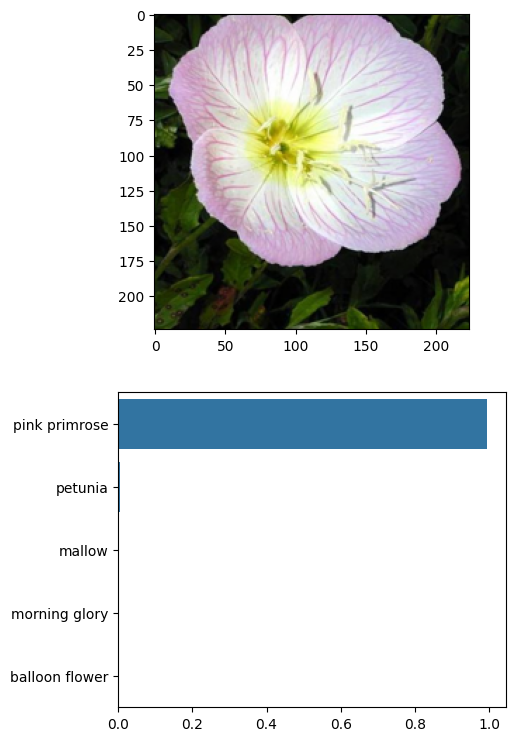

Prediction completed successfully.


In [12]:
devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model.to(devices)
print("Model has loaded:", devices)

# Process and predict
imagepath = '/content/flowers/test/1/image_06743.jpg'
img = processimage(imagepath)
print("Image processed successfully.")

prob, classes = predict(imagepath, Model)
print("Prediction probabilities: ", prob)
print("Prediction class: ", classes)

# Display the result
plotsolution(imagepath, Model)
print("Prediction completed successfully.")